In [2]:
# Imports 
import gym
import numpy as np
from gym.spaces import Box
import gfootball.env as football_env
from gfootball.env import create_environment as _create_env
from gym.wrappers import FrameStack
import matplotlib.pyplot as plt
import torch

Get all the scenerios available

In [3]:
from gfootball.env.scenario_builder import all_scenarios
print(all_scenarios())

['11_vs_11_competition', '11_vs_11_easy_stochastic', '11_vs_11_hard_stochastic', '11_vs_11_kaggle', '11_vs_11_stochastic', '1_vs_1_easy', '5_vs_5', 'academy_3_vs_1_with_keeper', 'academy_corner', 'academy_counterattack_easy', 'academy_counterattack_hard', 'academy_empty_goal', 'academy_empty_goal_close', 'academy_pass_and_shoot_with_keeper', 'academy_run_pass_and_shoot_with_keeper', 'academy_run_to_score', 'academy_run_to_score_with_keeper', 'academy_single_goal_versus_lazy', 'test_example_multiagent', 'tests']


We will use the stacked extracted representation of the game as it gave the best results in the original paper. (We will have to transpose the observation before feeding it to pytorch) 

In [4]:
env = football_env.create_environment(
    env_name='11_vs_11_stochastic',
    representation='extracted',
    stacked=True,
    number_of_left_players_agent_controls=1,
    render=False
)
print(env.observation_space.shape)  # -> (72, 96, 16)
print(env.action_space)  # -> Discrete(19)
print(env.reward_range)

(72, 96, 16)
Discrete(19)
(-inf, inf)


Lets display what our observation looks like

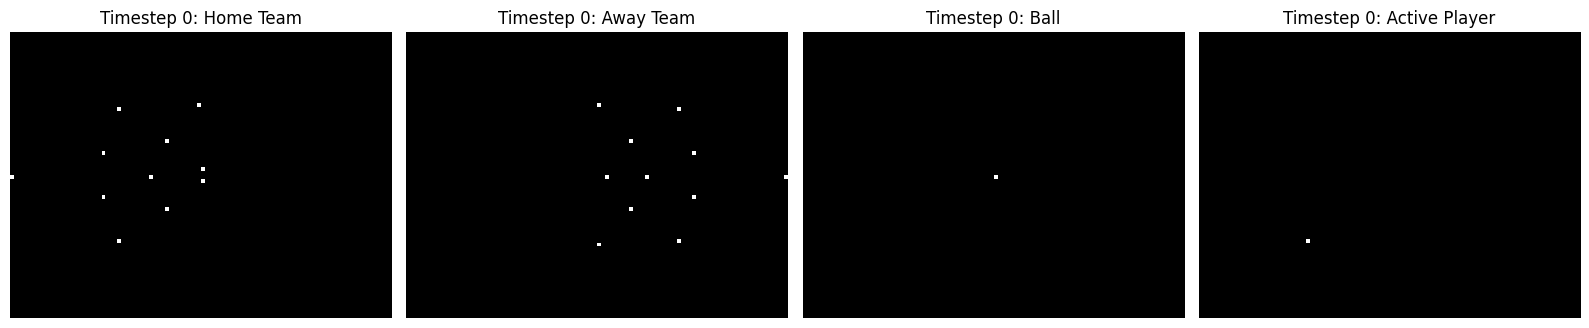

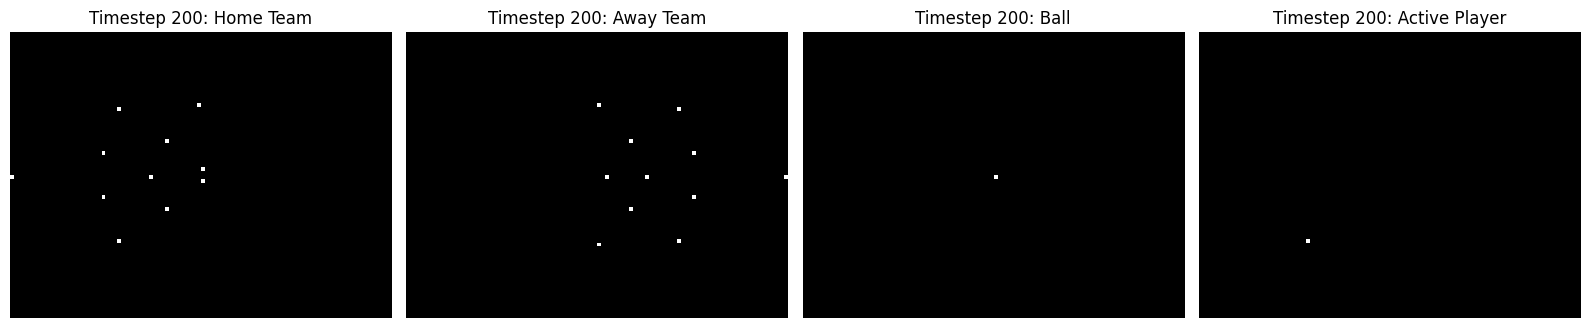

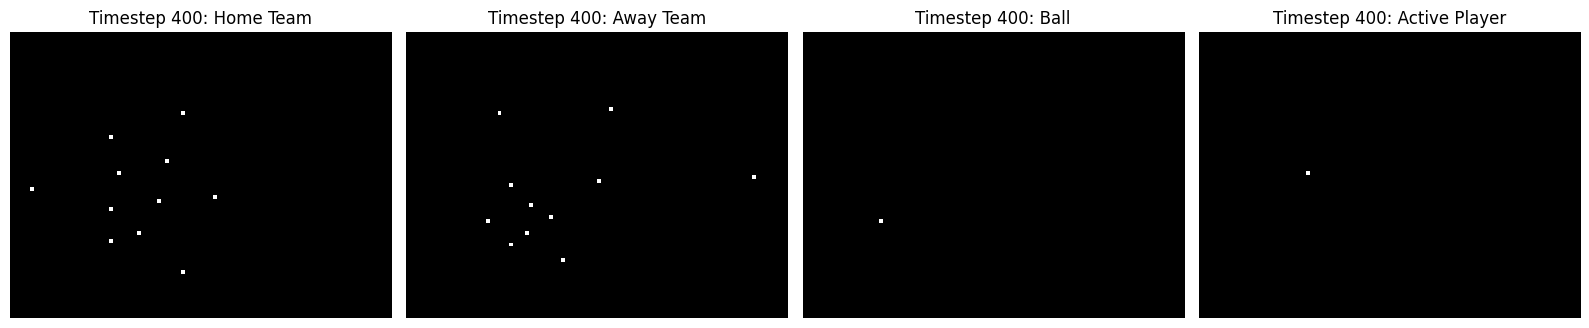

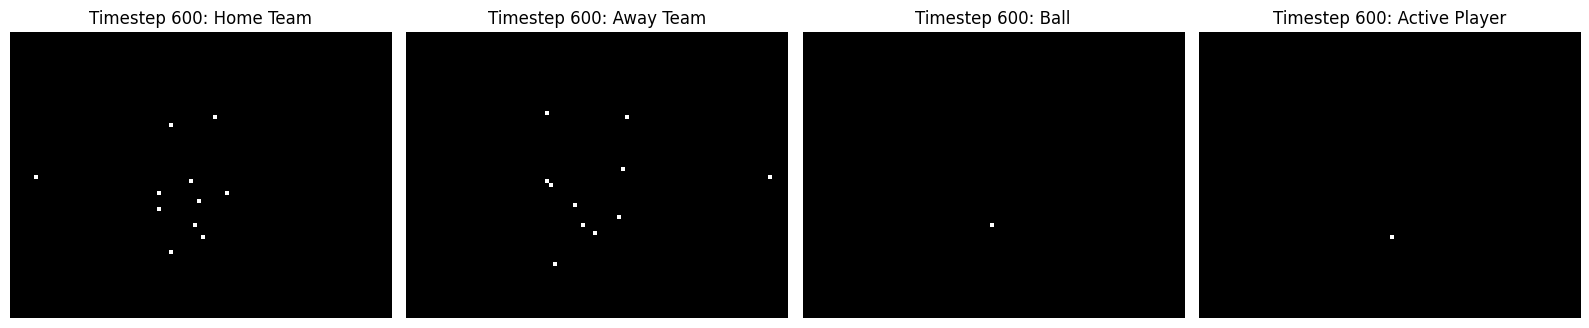

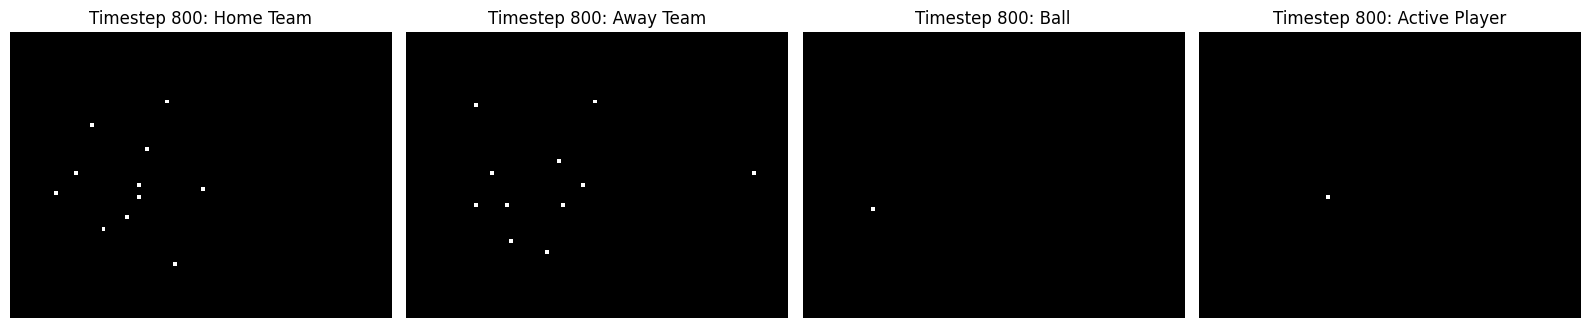

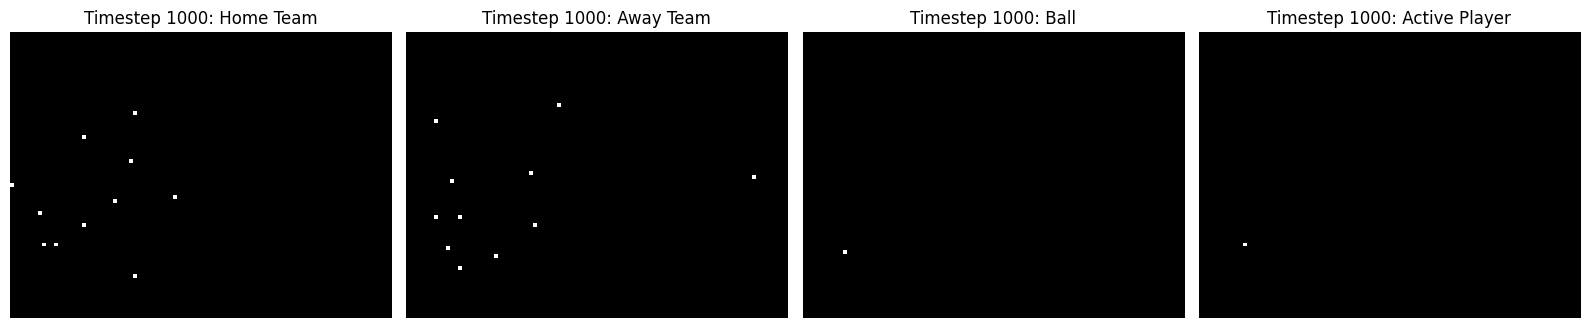

In [5]:
# Reset and collect the first frame (t=0)
frames = []
obs = env.reset()  # obs.shape == (72, 96, 16)
frames.append(obs)

# 3) Step and collect every 10th stacked frame
for step in range(1000):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    

    if step % 200 == 0:
        # reshape from (72,96,16) → (H=72, W=96, stack=4, channels=4,)
        obs4 = obs.reshape(72, 96, 4, 4)

        # iterate over the 4 stacked frames
        for k in range(obs4.shape[2]):
            # obs4[k] has shape (72,96,4): (H, W, channels)

            frame = obs4[:, :, k, :]  # shape: (72, 96, 4)
            frames.append(frame)
            break


    if done:
        break
# 4) Visualize
plane_names = ['Home Team', 'Away Team', 'Ball', 'Active Player']

for t, frame in enumerate(frames):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i, ax in enumerate(axes):
        ax.imshow(frame[:, :, i], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'Timestep {t*200}: {plane_names[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
# TODO 1: Reward Engineering
# TODO 2: Action Blocking
# TODO 3: Create your CNN-PPO 
# TODO 4: Train you agent on the easiest academy scenerio
# TODO 5: Figure out if you can visualize your agent with pixels after training it on the extracted representation

dPPO architecture used in the paper 

input: (72, 96, 16) (they have used tensorflow, we will transpose this to (16, 72, 96) to use pytorch) <br>
x4: 

# Policy and Value Network

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import gym
import torch.nn.functional as F
from collections import deque
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        residual = x
        out = self.relu(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out+residual)
        return out
    
class ConvPPO(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        C,H,W = input_shape
        self.num_actions = num_actions
        self.relu = nn.ReLU()
        
        # first group of layers
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1)
        self.max1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.res1a = ResidualBlock(16)
        self.res1b =ResidualBlock(16)

        # Second stage: 16 → 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.max2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.res2a = ResidualBlock(32)
        self.res2b = ResidualBlock(32)

        # Third stage
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.max3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.res3a = ResidualBlock(32)
        self.res3b = ResidualBlock(32)

        # Fourth stage
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.max4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.res4a = ResidualBlock(32)
        self.res4b = ResidualBlock(32)

        # Dynamically compute FC input size
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            dummy = self._forward_conv(dummy)
            self.flattened_size = dummy.view(1, -1).size(1)

        self.fc = nn.Linear(self.flattened_size, 256)
        self.policy = nn.Linear(256, num_actions)
        self.value = nn.Linear(256, 1)

    def forward_conv(self, x):
        x = self.conv1(x)
        x = self.max1(x)
        x = self.res1a(x)
        x = self.res1b(x)

        x = self.conv2(x)
        x = self.max2(x)
        x = self.res2a(x)
        x = self.res2b(x)

        x = self.conv3(x)
        x = self.max3(x)
        x = self.res3a(x)
        x = self.res3b(x)

        x = self.conv4(x)
        x = self.max4(x)
        x = self.res4a(x)
        x = self.res4b(x)
        return x
    
    def forward(self,x):
        x = x /255
        x = self.forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc(x))
        return self.policy(x), self.value(x)
    

# PPO Agent

In [9]:
# ----- Rollout Buffer -----
class RolloutBuffer:
    def __init__(self):
        self.clear()

    def clear(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []

    def add(self, state, action, log_prob, reward, done, value):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

    def compute_returns_and_advantages(self, last_value, gamma=0.99, lam=0.95):
        values = self.values + [last_value]
        gae = 0
        advantages = []
        returns = []

        for t in reversed(range(len(self.rewards))):
            delta = self.rewards[t] + gamma * values[t + 1] * (1 - self.dones[t]) - values[t]
            gae = delta + gamma * lam * (1 - self.dones[t]) * gae
            advantages.insert(0, gae)
            returns.insert(0, gae + values[t])
        return advantages, returns

# ----- PPO Update -----
def ppo_update(model, optimizer, buffer, clip_eps=0.2, vf_coef=0.5, ent_coef=0.01, batch_size=64, epochs=4):
    states = torch.stack(buffer.states).to(device)
    actions = torch.tensor(buffer.actions).to(device)
    old_log_probs = torch.stack(buffer.log_probs).to(device)
    values = torch.tensor(buffer.values).to(device).detach()

    advantages, returns = buffer.compute_returns_and_advantages(last_value=0.0)
    advantages = torch.tensor(advantages).float().to(device)
    returns = torch.tensor(returns).float().to(device)

    for _ in range(epochs):
        for i in range(0, len(states), batch_size):
            s_batch = states[i:i+batch_size]
            a_batch = actions[i:i+batch_size]
            old_logp = old_log_probs[i:i+batch_size]
            adv_batch = advantages[i:i+batch_size]
            ret_batch = returns[i:i+batch_size]

            logits, new_values = model(s_batch)
            dist = Categorical(logits=logits)
            new_logp = dist.log_prob(a_batch)
            entropy = dist.entropy().mean()

            ratio = (new_logp - old_logp).exp()
            surr1 = ratio * adv_batch
            surr2 = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * adv_batch
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss = F.mse_loss(new_values.squeeze(), ret_batch)

            loss = policy_loss + vf_coef * value_loss - ent_coef * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# ----- Training Loop -----
def train_ppo(env_name="CartPole-v1", total_timesteps=100_000, rollout_steps=2048, update_epochs=4):
    env = gym.make(env_name)
    obs_shape = (16, 72, 96)
    num_actions = env.action_space.n

    model = ConvPPO(input_shape=obs_shape, num_actions=num_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=2.5e-4)
    buffer = RolloutBuffer()

    obs = env.reset()
    done = False

    for step in range(total_timesteps):
        obs = torch.tensor(obs, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # (H,W,C) → (B,C,H,W)
        with torch.no_grad():
            logits, value = model(obs)
            dist = Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)

        next_obs, reward, done, _ = env.step(action.item())

        buffer.add(
            obs.squeeze(0).cpu(),
            action.item(),
            log_prob.cpu(),
            reward,
            done,
            value.item()
        )

        obs = next_obs

        if done:
            obs = env.reset()

        if (step + 1) % rollout_steps == 0:
            ppo_update(model, optimizer, buffer)
            buffer.clear()
            print(f"[Step {step + 1}] PPO update completed")

# ----- Run -----
if __name__ == "__main__":
    train_ppo(env_name='academy_empty_goal_close')  # replace with your actual env


Error: Attempted to look up malformed environment ID: b'academy_empty_goal_close'. (Currently all IDs must be of the form ^(?:[\w:-]+\/)?([\w:.-]+)-v(\d+)$.)